# Data Processing and Visualization
-----
**Assignment Topic: Data Analysis on Car Advertisements**

Group Number: 6

Student1 Name: Liam Barry

SNumber: 5221080

Student2 Name: Ben White

SNumber: 2850345

Student3 Name: Trieu Duong Phan

SNumber: 5377770

# Data Import

In [36]:
from google.colab import drive
drive.mount("/content/drive")
path = "/content/drive/My Drive/Dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
car_data = pd.read_csv(path + "car_dataset.csv")
sellers_data = pd.read_csv(path + "seller_dataset.csv")

# 1. Data Formatting

## a. Numerical Conversion

In [40]:
def numerical_conversion(df, columns):

    for column in columns:
        if df[column].astype(str).str.contains("L/100Km", regex=False).any():
            df[column] = df[column].replace("L/100Km", "", regex=True)
            df[column] = df[column].str.extract(r"(\d*\.?\d+)", expand=False)
        else:
            df[column] = df[column].replace(r"[^\d.]", "", regex=True)

        df[column] = df[column].astype(float)

    return df

columns_to_convert = ['mileage', 'num_of_doors', 'seating_capacity', 'fuel_consumption', 'price (AUD)']

car_data = numerical_conversion(car_data, columns_to_convert)

car_data[['num_of_doors', 'seating_capacity']] = car_data[['num_of_doors', 'seating_capacity']].astype(int)

car_data.head()

,ad_id,origin,condition,car_model,mileage,exterior_color,interior_color,num_of_doors,seating_capacity,engine,fuel_system,transmission,drive_type,fuel_consumption,brand,grade,year_of_manufacture,car_name,price (AUD)
0,17042,Domestic assembly,New car,Truck,0.0,White,gray,2,2,Petrol\t1.0 L,NaN,Manual,RFD - Rear-wheel drive,NaN,Suzuki,Super Carry Truck,2022.0,Suzuki Super Carry Truck 1.0 MT 2022,10080.99411
1,53794,Imported,New car,SUV,0.0,Black,Black,5,7,Petrol\t3.4 L,NaN,Automatic,AWD - 4-wheel drive (AWD),10.0,Toyota,Land Cruiser,2022.0,Toyota Land Cruiser 3.5 V6 2022,161943.68050
2,73954,Domestic assembly,New car,Crossover,0.0,Silver,Brown,5,8,Petrol\t2.0 L,NaN,Automatic,RFD - Rear-wheel drive,NaN,Toyota,Innova,2023.0,Toyota Innova G 2.0 AT 2023 car,35830.03930
3,74150,Imported,New car,SUV,0.0,White,Black,5,5,Petrol\t1.8 L,NaN,Automatic,FWD - Front-wheel drive,NaN,Toyota,Corolla Cross,2023.0,Toyota Corolla Cross 1.8G 2023,30526.38376
4,87573,Domestic assembly,New car,Crossover,0.0,Silver,gray,5,8,Petrol\t2.0 L,NaN,Automatic,RFD - Rear-wheel drive,NaN,Toyota,Innova,2022.0,Toyota Innova G 2.0 AT 2022 car,34413.03209


## b. Engine Feature Split

In [41]:
engine_split = car_data['engine'].str.split("\t", expand=True)
car_data['type_of_engine'] = engine_split[0]
car_data['engine_capacity'] = engine_split[1]

car_data.drop('engine', axis=1, inplace=True)

car_data = numerical_conversion(car_data, ['engine_capacity'])

car_data.head()

,ad_id,origin,condition,car_model,mileage,exterior_color,interior_color,num_of_doors,seating_capacity,fuel_system,transmission,drive_type,fuel_consumption,brand,grade,year_of_manufacture,car_name,price (AUD),type_of_engine,engine_capacity
0,17042,Domestic assembly,New car,Truck,0.0,White,gray,2,2,NaN,Manual,RFD - Rear-wheel drive,NaN,Suzuki,Super Carry Truck,2022.0,Suzuki Super Carry Truck 1.0 MT 2022,10080.99411,Petrol,1.0
1,53794,Imported,New car,SUV,0.0,Black,Black,5,7,NaN,Automatic,AWD - 4-wheel drive (AWD),10.0,Toyota,Land Cruiser,2022.0,Toyota Land Cruiser 3.5 V6 2022,161943.68050,Petrol,3.4
2,73954,Domestic assembly,New car,Crossover,0.0,Silver,Brown,5,8,NaN,Automatic,RFD - Rear-wheel drive,NaN,Toyota,Innova,2023.0,Toyota Innova G 2.0 AT 2023 car,35830.03930,Petrol,2.0
3,74150,Imported,New car,SUV,0.0,White,Black,5,5,NaN,Automatic,FWD - Front-wheel drive,NaN,Toyota,Corolla Cross,2023.0,Toyota Corolla Cross 1.8G 2023,30526.38376,Petrol,1.8
4,87573,Domestic assembly,New car,Crossover,0.0,Silver,gray,5,8,NaN,Automatic,RFD - Rear-wheel drive,NaN,Toyota,Innova,2022.0,Toyota Innova G 2.0 AT 2022 car,34413.03209,Petrol,2.0


## c. Standardizing Text Data

In [42]:
def standardize_text_data(df, columns):
    df[columns] = df[columns].apply(lambda x: x.str.lower())
    return df

columns_to_lowercase = ['origin', 'condition', 'car_model', 'exterior_color', 'interior_color', 'type_of_engine',
                        'fuel_system', 'transmission', 'drive_type', 'brand', 'grade']

car_data = standardize_text_data(car_data, columns_to_lowercase)

car_data.head()

,ad_id,origin,condition,car_model,mileage,exterior_color,interior_color,num_of_doors,seating_capacity,fuel_system,transmission,drive_type,fuel_consumption,brand,grade,year_of_manufacture,car_name,price (AUD),type_of_engine,engine_capacity
0,17042,domestic assembly,new car,truck,0.0,white,gray,2,2,NaN,manual,rfd - rear-wheel drive,NaN,suzuki,super carry truck,2022.0,Suzuki Super Carry Truck 1.0 MT 2022,10080.99411,petrol,1.0
1,53794,imported,new car,suv,0.0,black,black,5,7,NaN,automatic,awd - 4-wheel drive (awd),10.0,toyota,land cruiser,2022.0,Toyota Land Cruiser 3.5 V6 2022,161943.68050,petrol,3.4
2,73954,domestic assembly,new car,crossover,0.0,silver,brown,5,8,NaN,automatic,rfd - rear-wheel drive,NaN,toyota,innova,2023.0,Toyota Innova G 2.0 AT 2023 car,35830.03930,petrol,2.0
3,74150,imported,new car,suv,0.0,white,black,5,5,NaN,automatic,fwd - front-wheel drive,NaN,toyota,corolla cross,2023.0,Toyota Corolla Cross 1.8G 2023,30526.38376,petrol,1.8
4,87573,domestic assembly,new car,crossover,0.0,silver,gray,5,8,NaN,automatic,rfd - rear-wheel drive,NaN,toyota,innova,2022.0,Toyota Innova G 2.0 AT 2022 car,34413.03209,petrol,2.0


## d. Numerical Scaling

In [43]:
numerical_columns = ['engine_capacity', 'num_of_doors', 'seating_capacity', 'fuel_consumption', 'price (AUD)']

scaler = MinMaxScaler()
car_data[['normalised_' + column for column in numerical_columns]] = scaler.fit_transform(car_data[numerical_columns])

car_data.head()

,ad_id,origin,condition,car_model,mileage,exterior_color,interior_color,num_of_doors,seating_capacity,fuel_system,...,year_of_manufacture,car_name,price (AUD),type_of_engine,engine_capacity,normalised_engine_capacity,normalised_num_of_doors,normalised_seating_capacity,normalised_fuel_consumption,normalised_price (AUD)
0,17042,domestic assembly,new car,truck,0.0,white,gray,2,2,NaN,...,2022.0,Suzuki Super Carry Truck 1.0 MT 2022,10080.99411,petrol,1.0,0.071429,0.037037,0.042553,NaN,0.004611
1,53794,imported,new car,suv,0.0,black,black,5,7,NaN,...,2022.0,Toyota Land Cruiser 3.5 V6 2022,161943.68050,petrol,3.4,0.261905,0.092593,0.148936,0.00005,0.074074
2,73954,domestic assembly,new car,crossover,0.0,silver,brown,5,8,NaN,...,2023.0,Toyota Innova G 2.0 AT 2023 car,35830.03930,petrol,2.0,0.150794,0.092593,0.170213,NaN,0.016389
3,74150,imported,new car,suv,0.0,white,black,5,5,NaN,...,2023.0,Toyota Corolla Cross 1.8G 2023,30526.38376,petrol,1.8,0.134921,0.092593,0.106383,NaN,0.013963
4,87573,domestic assembly,new car,crossover,0.0,silver,gray,5,8,NaN,...,2022.0,Toyota Innova G 2.0 AT 2022 car,34413.03209,petrol,2.0,0.150794,0.092593,0.170213,NaN,0.015741


In [44]:
# Save processed data to a new CSV file
car_data.to_csv(path + "processed_car_dataset.csv", index=False)

# 2. Data Exploration and Cleaning

In [45]:
processed_car_data = pd.read_csv(path + "processed_car_dataset.csv")

## a. Statistics Computation

In [46]:
columns_to_calculate = ['price (AUD)', 'mileage', 'year_of_manufacture']

def calculate_range(column):
    return column.max() - column.min()

for column in columns_to_calculate:
    mean = processed_car_data[column].mean()
    median = processed_car_data[column].median()
    mode = processed_car_data[column].mode()[0]   # take the first mode if multiple exist
    std = processed_car_data[column].std()
    data_range = calculate_range(processed_car_data[column])

    stats_dict = {
        'Mean': mean,
        'Median': median,
        'Mode': mode,
        'Std Dev': std,
        'Range': data_range
    }

    stats_df = pd.DataFrame(stats_dict, index=[column]).T

    print(f"Calculated statistics for the variable '{column}':")
    display(stats_df)

Calculated statistics for the variable 'price (AUD)':


,price (AUD)
Mean,4.284316e+04
Median,2.493933e+04
Mode,4.048592e+04
Std Dev,7.858559e+04
Range,2.186240e+06


Calculated statistics for the variable 'mileage':


,mileage
Mean,4.123150e+05
Median,2.000000e+04
Mode,0.000000e+00
Std Dev,3.489966e+07
Range,4.294967e+09


Calculated statistics for the variable 'year_of_manufacture':


,year_of_manufacture
Mean,2017.320346
Median,2019.000000
Mode,2023.000000
Std Dev,5.331772
Range,33.000000


## b. Outliers and Missing Values

### i. Checking and addressing outliers

In [47]:
initial_rows = processed_car_data.shape[0]

numerical_columns = processed_car_data.select_dtypes(include='number').columns
numerical_columns = numerical_columns.drop('ad_id').tolist()

Q1 = processed_car_data[numerical_columns].quantile(0.25)
Q3 = processed_car_data[numerical_columns].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((processed_car_data[numerical_columns] < lower_bound) | (processed_car_data[numerical_columns] > upper_bound)).sum()

print("Outliers across all numerical columns:")
outliers

Outliers across all numerical columns:


,0
mileage,1050
num_of_doors,769
seating_capacity,225
fuel_consumption,565
year_of_manufacture,887
price (AUD),3767
engine_capacity,1076
normalised_engine_capacity,1076
normalised_num_of_doors,769
normalised_seating_capacity,259


In [48]:
print("Percentage of outliers in the numerical columns:")
for column in numerical_columns:
    count = outliers[column]
    if count > 0:
        percentage = (count / initial_rows) * 100
        print(f"\t{column}: {percentage:.2f}%")

outlier_matrix = (processed_car_data[numerical_columns] < lower_bound) | (processed_car_data[numerical_columns] > upper_bound)

rows_with_outliers = outlier_matrix.any(axis=1)
percentage_unique_rows = (rows_with_outliers.sum() / processed_car_data.shape[0]) * 100

print(f"\nPercentage of rows with at least one outlier: {percentage_unique_rows:.2f}%")

Percentage of outliers in the numerical columns:
	mileage: 3.43%
	num_of_doors: 2.51%
	seating_capacity: 0.73%
	fuel_consumption: 1.84%
	year_of_manufacture: 2.89%
	price (AUD): 12.29%
	engine_capacity: 3.51%
	normalised_engine_capacity: 3.51%
	normalised_num_of_doors: 2.51%
	normalised_seating_capacity: 0.84%
	normalised_fuel_consumption: 1.88%
	normalised_price (AUD): 12.29%

Percentage of rows with at least one outlier: 21.84%


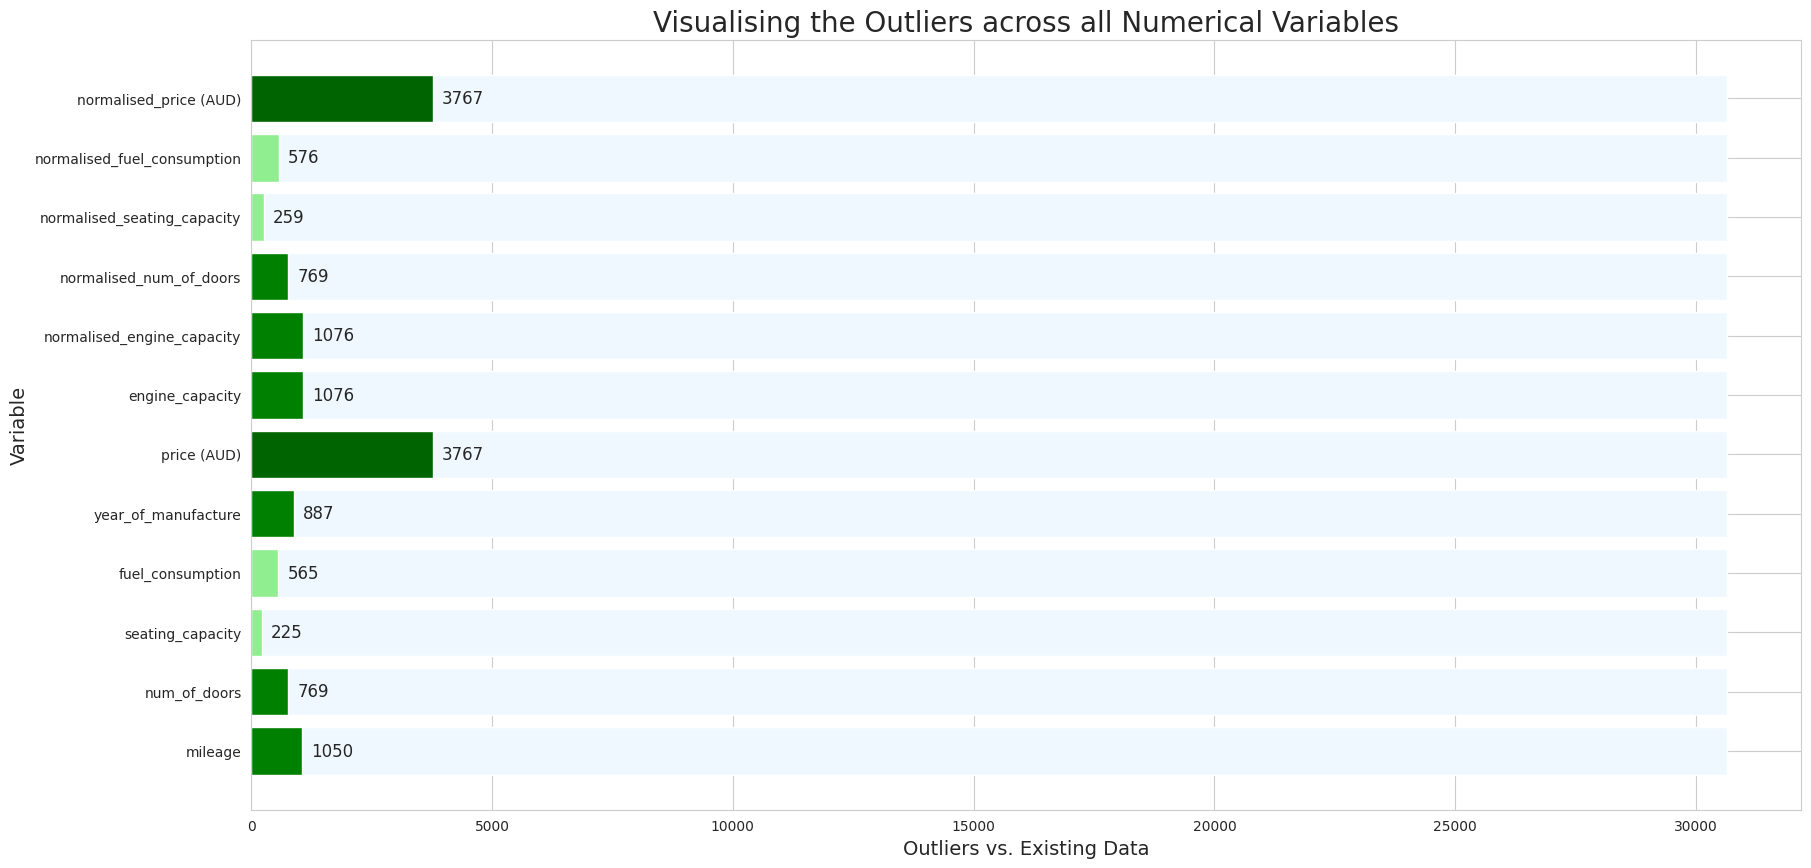

In [49]:
def colourize_outliers(value, maxValue):
    low, high = maxValue * 0.2, maxValue * 0.66
    if value <= low:
        return 'lightgreen'
    elif value >= high:
        return 'darkgreen'
    else:
        return 'green'

cols = [colourize_outliers(n, outliers.max()) for n in outliers]
total_data = [processed_car_data.shape[0]] * len(numerical_columns)

plt.figure(figsize=(20,10))
plt.barh(numerical_columns, total_data, color='aliceblue')
plt.barh(numerical_columns, outliers, color=cols)

plt.title('Visualising the Outliers across all Numerical Variables', size=20)
plt.xlabel('Outliers vs. Existing Data', size=14)
plt.ylabel('Variable', size=14)

for index, value in enumerate(outliers.values):
    plt.text(value + outliers.max() * 0.05, index, str(value), va='center', ha='left', fontsize=12)

plt.show()

In [50]:
cleaned_car_data = processed_car_data[~((processed_car_data[numerical_columns] < lower_bound) | (processed_car_data[numerical_columns] > upper_bound)).any(axis=1)]

final_rows = cleaned_car_data.shape[0]

outliers_removed = initial_rows - final_rows
print(f"Number of outliers removed: {outliers_removed}")

Number of outliers removed: 6693


### ii. Identifying and handling missing values

In [51]:
missing_data = cleaned_car_data.isna().sum()
print("Missing values across the dataset:")
missing_data

Missing values across the dataset:


,0
ad_id,0
origin,0
condition,0
car_model,0
mileage,0
exterior_color,0
interior_color,0
num_of_doors,0
seating_capacity,0
fuel_system,18697


In [52]:
print("Percentage of missing data in the dataset:")
totalPercentage = 0
for i in range(len(missing_data)):
    if missing_data.iloc[i] > 0:
        percentage = missing_data.iloc[i] / cleaned_car_data.shape[0]
        totalPercentage += percentage
        print(f"\t{cleaned_car_data.columns[i]}: {percentage:.2f}%")

print(f"\nTotal missing data in the dataset: {totalPercentage:.2f}%")

Percentage of missing data in the dataset:
	fuel_system: 0.78%
	fuel_consumption: 0.62%
	year_of_manufacture: 0.00%
	engine_capacity: 0.03%
	normalised_engine_capacity: 0.03%
	normalised_fuel_consumption: 0.62%

Total missing data in the dataset: 2.09%


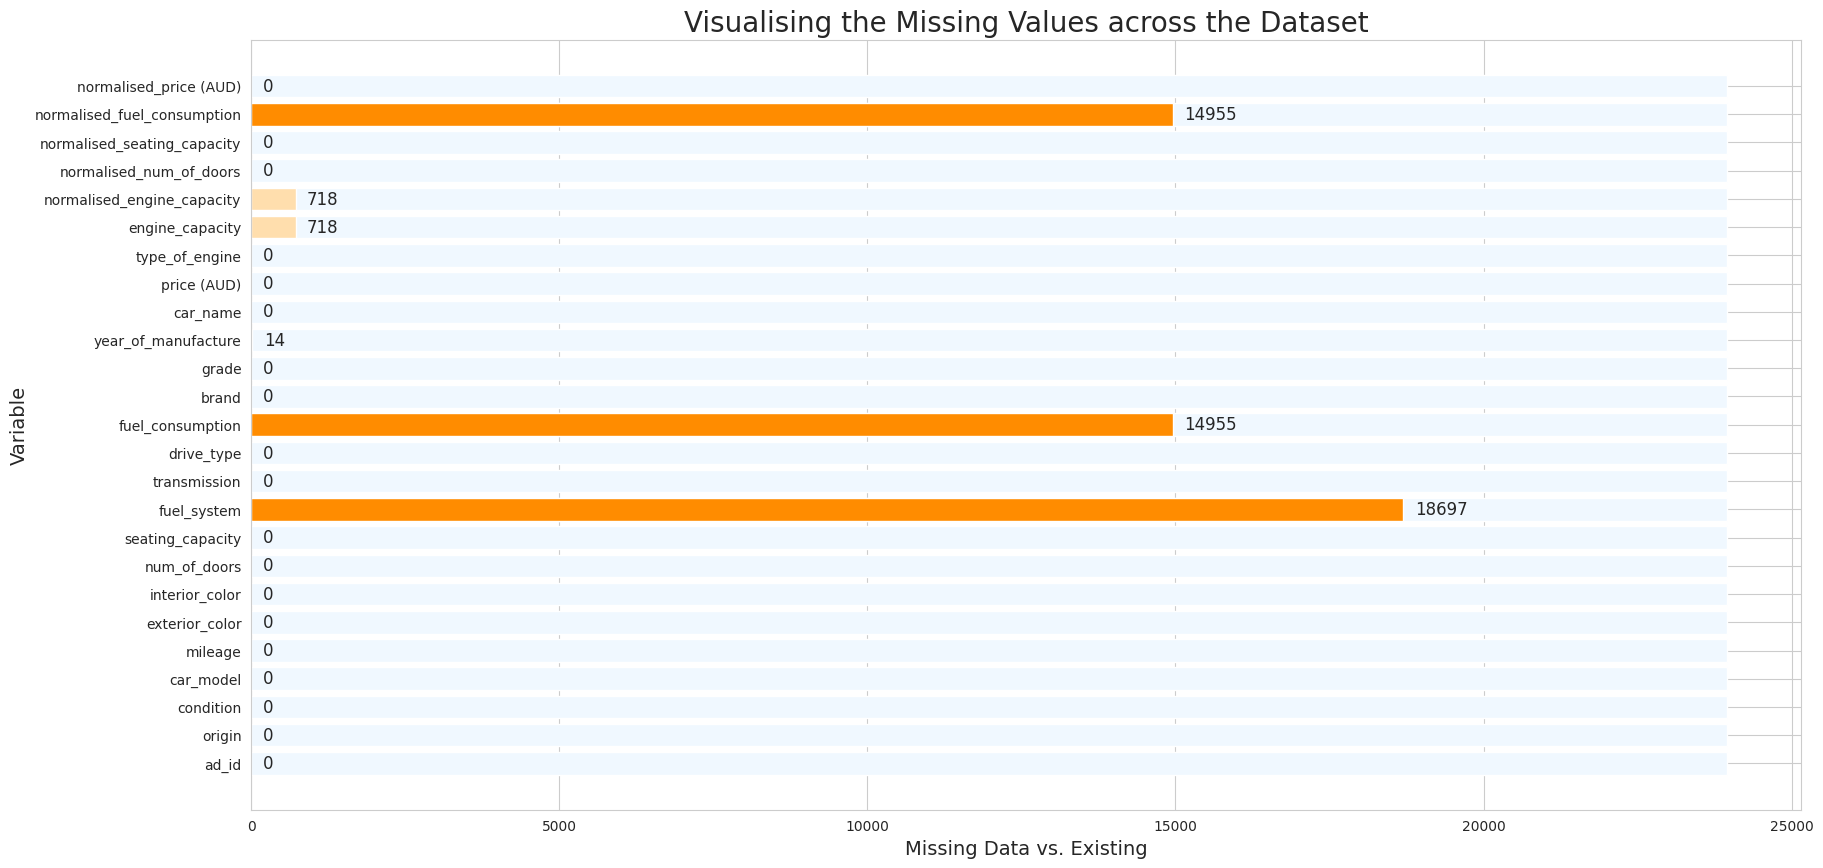

In [53]:
# Visualising the missing data
def colourize_bar(value, maxValue):
    low, high = maxValue * 0.2, maxValue * 0.66
    if(value <= low):
        return 'navajowhite'
    elif(value >= high):
        return 'darkorange'
    else:
        return 'orange'

cols = [colourize_bar(n, missing_data.max()) for n in missing_data]
total_data = [cleaned_car_data.shape[0]] * cleaned_car_data.shape[1]

plt.figure(figsize=(20,10))
plt.barh(cleaned_car_data.columns.values, total_data, color='aliceblue')
plt.barh(cleaned_car_data.columns.values, missing_data, color=cols)

plt.title('Visualising the Missing Values across the Dataset', size=20)
plt.xlabel('Missing Data vs. Existing', size=14)
plt.ylabel('Variable', size=14)

for index, value in enumerate(missing_data.values):
    plt.text(value + missing_data.max() * 0.01, index, str(value), va='center', ha='left', fontsize=12)

plt.show()

In [54]:
# Imputing missing values using RandomForest predictive modeling.
def impute_missing_values(df, target_col, is_categorical, excluded_cols):

    train = df[df[target_col].notna()]
    test = df[df[target_col].isna()]

    if train.empty or test.empty:
        print(f"Skipping '{target_col}' as it has no missing values or all values are missing.")
        return df

    X = train.drop(columns=[target_col] + excluded_cols, errors='ignore')
    y = train[target_col]

    X_test = test.drop(columns=[target_col] + excluded_cols, errors='ignore')

    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Defining preprocessing for categorical and numerical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])

    if is_categorical:
        model = RandomForestClassifier(random_state=101, n_jobs=-1)
    else:
        model = RandomForestRegressor(random_state=101, n_jobs=-1)

    # Create a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X, y)

    y_pred = pipeline.predict(X_test)

    if is_categorical:
        y_pred = y_pred.astype(df[target_col].dtype)

    # Assign the predicted values
    df.loc[df[target_col].isna(), target_col] = y_pred

    return df

In [55]:
# List of variables with missing values and their types
imputation_order = [
    ('year_of_manufacture', False),
    ('engine_capacity', False),
    ('normalised_engine_capacity', False),
    ('fuel_consumption', False),
    ('normalised_fuel_consumption', False),
    ('fuel_system', True)
]

# Initialize excluded_cols with all missing variables
missing_vars = [var for var, _ in imputation_order]
excluded_cols = missing_vars.copy()

for target, is_cat in imputation_order:
    print(f"Imputing '{target}'...")

    # Exclude all variables with missing values except the current target
    current_excluded = [var for var in excluded_cols if var != target]

    cleaned_car_data = impute_missing_values(cleaned_car_data, target, is_cat, current_excluded)

    # Casting year to be an integer
    if target == 'year_of_manufacture':
        cleaned_car_data.loc[:, target] = cleaned_car_data[target].astype(int)

    print(f"'{target}' imputed.\n")

    # After imputation, remove the target from excluded_cols
    excluded_cols.remove(target)

Imputing 'year_of_manufacture'...
'year_of_manufacture' imputed.

Imputing 'engine_capacity'...
'engine_capacity' imputed.

Imputing 'normalised_engine_capacity'...
'normalised_engine_capacity' imputed.

Imputing 'fuel_consumption'...
'fuel_consumption' imputed.

Imputing 'normalised_fuel_consumption'...
'normalised_fuel_consumption' imputed.

Imputing 'fuel_system'...
'fuel_system' imputed.



In [56]:
print("Missing values after predictive modeling:")
print(cleaned_car_data.isna().sum())

Missing values after predictive modeling:
ad_id                          0
origin                         0
condition                      0
car_model                      0
mileage                        0
exterior_color                 0
interior_color                 0
num_of_doors                   0
seating_capacity               0
fuel_system                    0
transmission                   0
drive_type                     0
fuel_consumption               0
brand                          0
grade                          0
year_of_manufacture            0
car_name                       0
price (AUD)                    0
type_of_engine                 0
engine_capacity                0
normalised_engine_capacity     0
normalised_num_of_doors        0
normalised_seating_capacity    0
normalised_fuel_consumption    0
normalised_price (AUD)         0
dtype: int64


In [57]:
print(f"Before cleaning data: {processed_car_data.shape[0]} rows.")
print(f"After cleaning data: {cleaned_car_data.shape[0]} rows.")

Before cleaning data: 30652 rows.
After cleaning data: 23959 rows.


In [58]:
# Save cleaned data to a new CSV file
cleaned_car_data.to_csv(path + "cleaned_car_dataset.csv", index=False)

# 3. Data Storage

In [59]:
con = sqlite3.connect("carAdverts.db")
cur = con.cursor()

## a. Creating Cars Table & b. Creating Sellers Table

In [60]:
fileNames = ["cleaned_car", "seller"]
fileStructures = {
    "Cars": {
        "ad_id": "ad_id INTEGER PRIMARY KEY",
        "car_name": "car_name VARCHAR(255)",
        "origin": "origin VARCHAR(255)",
        "condition": "condition VARCHAR(255)",
        "exterior_color": "exterior_color VARCHAR(255)",
        "car_model": "car_model VARCHAR(255)",
        "year_of_manufacture": "year_of_manufacture VARCHAR(255)",
        "transmission": "transmission VARCHAR(255)",
        "price": "price INTEGER",
        "drive_type": "drive_type VARCHAR(255)"
    },
    "Sellers": {
        "ad_id": "ad_id INTEGER PRIMARY KEY",
        "seller_name": "seller_name TEXT"
    }
}

tableNames = {
    "cleaned_car": "Cars",
    "seller": "Sellers"
}

In [61]:
def readCSV(csvName, fileStructure, tableName):
    ## READ CSV + HEADERS #
    with open(path + f"{csvName}_dataset.csv", "r") as csvFile:
        dictReader = csv.DictReader(csvFile)
        dictHeaders = dictReader.fieldnames # column names

        columnMapping = {
            "price (AUD)": "price",
            "name": "seller_name"
        }

        adjustedHeaders = [
            columnMapping.get(colName, colName) for colName in dictHeaders
        ]

        toInsert = [
            [dictRow.get(dictKey) for dictKey in dictHeaders if columnMapping.get(dictKey, dictKey) in fileStructure]
            for dictRow in dictReader
        ]
    ## READ CSV + HEADERS #

    ## CREATE TABLE ##
    cur.execute(f"DROP TABLE IF EXISTS {tableName};")

    insertColumns = []
    for colName in adjustedHeaders:
        if colName in fileStructure:
            insertColumns.append(fileStructure[colName])
    createString = ', '.join(insertColumns)

    sqlQuery = f"CREATE TABLE IF NOT EXISTS {tableName} ({createString});"
    cur.execute(sqlQuery)
    ## CREATE TABLE ##

    ## INSERT DATA ##
    insertHeaders = ", ".join([col for col in adjustedHeaders if col in fileStructure])
    insertValues = ", ".join("?" for _ in insertHeaders.split(", "))
    sqlQuery = f"INSERT INTO {tableName} ({insertHeaders}) VALUES ({insertValues});"
    cur.executemany(sqlQuery, toInsert)
    ## INSERT DATA ##

    print(f"Completed import for {tableName} with {len(cur.execute(f'SELECT * FROM {tableName}').fetchall())} rows...")


for fileName in fileNames:
    tableName = tableNames[fileName]
    fileStructure = fileStructures[tableName]
    readCSV(fileName, fileStructure, tableName)

OperationalError: database is locked

## c. Making the Query

In [ ]:
sqlQuery = """
    SELECT
        Cars.ad_id,
        Cars.car_name,
        Cars.price,
        Sellers.seller_name
    FROM Cars
    LEFT OUTER JOIN Sellers ON Cars.ad_id = Sellers.ad_id;
"""

cur.execute(sqlQuery)
results = cur.fetchall()
for row in results:
    print(row)

# Data Visualization

## a. Static Data Visualisation

In [ ]:
# Load the cleaned dataset
car_data = pd.read_csv(path + "cleaned_car_dataset.csv")

### i. Relationship between 'mileage' and 'price'

In [ ]:
plt.figure(figsize=(10, 6))

sns.regplot(x='mileage', y='price (AUD)', data=car_data, label='Car Data',
            scatter_kws={'color': 'royalblue', 'alpha': 0.2, 's': 10})
sns.regplot(x='mileage', y='price (AUD)', data=car_data, scatter=False, label='Regression Line',
            line_kws={'color': 'red'})

plt.title('Relationship between Mileage and Price', fontsize=14)
plt.xlabel('Mileage', fontsize=12)
plt.ylabel('Price (AUD)', fontsize=12)

plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The scatter plot above shows a negative trend between mileage and price, with higher mileage generally correlating to lower prices, as indicated by the downward-sloping trendline. However, there is significant variability, particularly at lower mileages, where prices still range widely. This suggests that while mileage affects pricing, other factors also play a role.

### ii. Trend of car prices over the 'year_of_m'

In [ ]:
year_price_mean = car_data.groupby('year_of_manufacture')['price (AUD)'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_price_mean, x='year_of_manufacture', y='price (AUD)', marker='o', color='#2ca02c', linewidth=2, label='Average Price Trend')

plt.title('Trend of Car Prices over Year of Manufacture', fontsize=16)
plt.xlabel('Year of Manufacture', fontsize=14)
plt.ylabel('Average Price (AUD)', fontsize=14)

years = year_price_mean['year_of_manufacture']
plt.xticks(rotation=45, ticks=years[::2])

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The line graph above shows a clear upward trend in car prices over the years of manufacture, indicating that newer cars generally have higher average prices. From 2005 to 2023, there is a steady increase, with significant price growth after 2010. The consistent rise suggests that factors such as newer technology, improved features, and perhaps inflation may contribute to this trend. This implies that the year of manufacture is an important factor in determining the price, with more recent cars typically being priced higher.

### iii. Average prices among different 'car_models'

In [ ]:
car_data_filtered = car_data[car_data['car_model'] != 'wagon']

model_price_mean = car_data_filtered.groupby('car_model')['price (AUD)'].mean().reset_index()
model_price_mean = model_price_mean.sort_values(by='price (AUD)', ascending=False)

plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')

bar_plot = sns.barplot(data=model_price_mean, x='car_model', y='price (AUD)', hue='car_model', palette='crest_r')

plt.title('Average Price of Different Car Models (Excluding Wagon)', fontsize=16)
plt.xlabel('Car Model', fontsize=14)
plt.ylabel('Average Price (AUD)', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)

for bar, label in zip(bar_plot.patches, model_price_mean['car_model']):
    bar.set_label(label)

plt.legend(title='Car Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The bar chart above compares the average prices of different car models. SUVs and convertibles/cabriolets have the highest average prices, both around 30,000 AUD, followed by coupes and 4x4s, which also show relatively high prices. Crossovers, sedans, and vans/minivans are in the middle range, while trucks are priced lower on average. Hatchbacks have the lowest average price, falling well below 20,000 AUD. This suggests that larger vehicles, such as SUVs and convertibles, tend to be more expensive, while smaller models like hatchbacks are generally more affordable.

### iv. Distribution of ‘engine_capacity’

In [ ]:
plt.figure(figsize=(12, 6))

ax = sns.histplot(data=car_data, x='engine_capacity', bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.6)
ax.lines[0].set_color('crimson')

plt.title('Distribution of Engine Capacity', fontsize=16)
plt.xlabel('Engine Capacity (L)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(labels=['KDE Curve', 'Engine Capacity Histogram'], title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The histogram and KDE curve above show the distribution of engine capacity. The data is bimodal, with two prominent peaks around 1.5L and 2.0L, indicating that most cars in the dataset have engines around these sizes. There are smaller groups of cars with engine capacities below 1.0L and a few with larger engines, up to around 3.5L. The distribution tails off as engine capacity increases, suggesting that higher-capacity engines are less common in the dataset. Overall, the most frequent engine sizes are between 1.0L and 2.0L.

### v. Distribution of the cars’ exterior colors as the percentage of a whole

In [ ]:
car_data = car_data[car_data['exterior_color'] != 'take note']

color_counts = car_data['exterior_color'].value_counts()

total_count = color_counts.sum()
threshold = 0.01 * total_count

top_colors = color_counts[color_counts >= threshold]
other_total = color_counts[color_counts < threshold].sum()

if other_total > 0:
    top_colors = pd.concat([top_colors, pd.Series({'Other': other_total})])

color_percentages = top_colors / total_count * 100

# Map each exterior color to its corresponding actual color
color_mapping = {
    'white': '#f0f0f0',
    'black': 'black',
    'red': 'red',
    'silver': 'silver',
    'green': 'green',
    'grey': 'grey',
    'brown': 'saddlebrown',
    'sand': 'sandybrown',
    'yellow': 'gold',
    'orange': 'orange',
    'Other': 'dodgerblue'
}

colors_to_use = [color_mapping.get(color, 'dodgerblue') for color in color_percentages.index]
explode_values = [0.1 if color == 'white' else 0 for color in color_percentages.index]

plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    color_percentages,
    explode=explode_values,
    labels=None,
    colors=colors_to_use,
    autopct=lambda pct: '{:.1f}%'.format(pct) if pct >= 1.5 else '',
    pctdistance=0.85,
    startangle=180,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'alpha': 0.7}
)

for i, autotext in enumerate(autotexts):
    autotext.set_fontsize(12)
    if color_percentages.index[i] == 'white':
        autotext.set_color('black')
    else:
        autotext.set_color('white')

plt.legend(title='Exterior Colors', labels=top_colors.index, loc="upper right", bbox_to_anchor=(1.2, 0.7))
plt.title('Distribution of Exterior Colors', fontsize=16)

plt.tight_layout()
plt.show()

The pie chart above displays the distribution of cars' exterior colours. White is the most common colour, accounting for 33.5% of the total, followed by black at 19.6% and red at 14.9%. Silver is also prevalent, making up 10.1%. Other colours, such as green, grey, brown, sand, yellow, orange, and others, represent smaller portions, with green being the most common among them at 7.4%. Overall, neutral car colours like white, black, and silver dominate, while more vibrant colours are less common.

### vi. Correlations between specified features

In [ ]:
plt.figure(figsize=(8, 6))

corr_matrix = car_data[['mileage', 'num_of_doors', 'seating_capacity', 'fuel_consumption', 'price (AUD)']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix of Selected Car Features', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

The correlation matrix above reveals several key relationships between the selected car features. Mileage has a moderate negative correlation with price (-0.22), indicating that higher mileage generally leads to lower prices. Fuel consumption has a moderate positive correlation with price (0.36), suggesting that cars with higher fuel consumption tend to have higher prices. Seating capacity also shows a moderate correlation with both the number of doors (0.43) and fuel consumption (0.33). Other correlations are relatively weak, such as mileage with fuel consumption (0.19) and price with seating capacity (0.19), indicating that these features don't have a strong connection. Additionally, some features show very low correlations. For example, mileage and seating capacity (0.0012), as well as the number of doors and fuel consumption (0.054), show almost no relationship, suggesting these features are largely independent of each other and don't influence one another in a meaningful way.

## b. Interactive Visualization Enhancement

### Link to completed ObservableHQ notebook:
### https://observablehq.com/d/f60da854f4fc5dff